# Import necessary libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, precision_recall_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from pandas.api.types import CategoricalDtype
import math
import numpy as np
import joblib

In [2]:
# definition of useful helpers
def labeling(df: pd.DataFrame, c_cols: list[str]) -> pd.DataFrame:
    # Encode categorical variables
    label_encoder = LabelEncoder()
    for col in c_cols:
        df[col] = label_encoder.fit_transform(df[col])
    return df


def save_model(model, filename: str | None = "model.joblib", debug: bool | None = False):
    joblib.dump(model, filename)
    if debug:
        print(f"Model saved as {filename}")


def load_model(filename: str | None = "model.joblib"):
    return joblib.load(filename)


def load_file(url: str) -> pd.DataFrame:
    return pd.read_csv(url)


def plot_columns(df: pd.DataFrame, cols: list[str], plot_type: int | None = None, n_subplots: int | None = 3):
    n_rows = math.ceil(len(cols) / n_subplots)

    plt.figure(figsize=(18, 12))
    for i, col in enumerate(cols, 1):
        plt.subplot(n_rows, n_subplots, i)
        if plot_type == "hist":
            sns.histplot(df[col], kde=True, bins=30)
        else:
            sns.countplot(x=col, hue="target", data=df)
        plt.title(f"Distribution of {col} by Target")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()


def feature_importance_plot(model, model_name: str, x: pd.DataFrame) -> np.ndarray:
    try:
        # Feature Importance
        feature_importances = pd.Series(model.feature_importances_, index=x.columns)
    except Exception as e:
        feature_importances = pd.Series(model.coefs_[0].mean(axis=1), index=x.columns)

    top_features = feature_importances.abs().sort_values(ascending=False).head(5)
    # Plotting Feature Importance
    top_features.plot(kind="barh")
    plt.title(f"Top 5 Important Features (model {model_name})")
    plt.show()
    return top_features


def partial_dependence_plot(model, model_name: str, x: pd.DataFrame, features: pd.core.series.Series, n_subplots: int | None = 3):
    def avg(value):
        x_temp = x.copy()
        x_temp[feature] = value
        return model.predict_proba(x_temp)[:, 1].mean()
    
    # Partial Dependence Plots (PDP)
    n_rows = math.ceil(len(features) / n_subplots)
    fig, axs = plt.subplots(n_rows, n_subplots, figsize=(18, 12))
    fig.suptitle(f"Partial Dependence Plots (model {model_name})")
    fig.supylabel("Average Predicted Probability")
    for i, feature in enumerate(features.keys()):
        feature_values = x[feature].unique()
        average_probabilities = [avg(value) for value in feature_values]

        # Plotting PDP
        current_axs = axs[int(i / n_subplots), i % n_subplots]
        current_axs.plot(feature_values, average_probabilities, marker="o")
        current_axs.set_xlabel(feature)

    for a in axs[n_rows - 1, n_subplots * (1 - n_rows) + len(features):]:
        a.set_axis_off()
    plt.subplots_adjust(bottom=0.1)
    fig.tight_layout()
    plt.show()

# Load the dataset

In [3]:
url = "../input/employee-churn-xtream/churn.csv"
df = load_file(url)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

# Analysis of variables

## Data exploration and preprocessing

In [5]:
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
enrollee_id,19158.0,16875.358179,9616.292592,1.000,8554.25,16982.500,25169.75,33380.000
city_development_index,19158.0,0.828848,0.123362,0.448,0.74,0.903,0.92,0.949
training_hours,19158.0,65.366896,60.058462,1.000,23.00,47.000,88.00,336.000
target,19158.0,0.249348,0.432647,0.000,0.00,0.000,0.00,1.000


In [7]:
for col in df.columns:
    print(f"values for column {col}\n", df[col].unique(), "\n\n", flush=True)

values for column enrollee_id
 [ 8949 29725 11561 ... 24576  5756 23834] 


values for column city
 ['city_103' 'city_40' 'city_21' 'city_115' 'city_162' 'city_176'
 'city_160' 'city_46' 'city_61' 'city_114' 'city_13' 'city_159' 'city_102'
 'city_67' 'city_100' 'city_16' 'city_71' 'city_104' 'city_64' 'city_101'
 'city_83' 'city_105' 'city_73' 'city_75' 'city_41' 'city_11' 'city_93'
 'city_90' 'city_36' 'city_20' 'city_57' 'city_152' 'city_19' 'city_65'
 'city_74' 'city_173' 'city_136' 'city_98' 'city_97' 'city_50' 'city_138'
 'city_82' 'city_157' 'city_89' 'city_150' 'city_70' 'city_175' 'city_94'
 'city_28' 'city_59' 'city_165' 'city_145' 'city_142' 'city_26' 'city_12'
 'city_37' 'city_43' 'city_116' 'city_23' 'city_99' 'city_149' 'city_10'
 'city_45' 'city_80' 'city_128' 'city_158' 'city_123' 'city_7' 'city_72'
 'city_106' 'city_143' 'city_78' 'city_109' 'city_24' 'city_134' 'city_48'
 'city_144' 'city_91' 'city_146' 'city_133' 'city_126' 'city_118' 'city_9'
 'city_167' 'city_27' 'c

Now, let me check how many rows have missing data. In this way, I could consider the opportunity to remove those rows without data, if the deletion doesn't bias the dataset.

In [8]:
df.isnull().sum()

enrollee_id                  0
city                         0
city_development_index       0
gender                    4508
relevent_experience          0
enrolled_university        386
education_level            460
major_discipline          2813
experience                  65
company_size              5938
company_type              6140
last_new_job               423
training_hours               0
target                       0
dtype: int64

Considering the dataset, I already have the city development index stating information about the cities: therefore the _city_ is not necessary. Similar considerations can be made for _relevent_experience_ and _experience_.

Moreover, we can make some other assumptions:
1. compared with the total amount of data, the number of rows without _education_level_, _enrolled_university_, _experience_ or _last_new_job_ are few. Therefore, I can drop them without the risk of making the dataset biased.
2. for the other features (like _gender_ or _major_discipline_ etc.), it is evident that I cannot remove the data with null values without affecting the robustness of the dataset.
3. I can assume that a candidate / employee has no previous company if his / her experience is less than 1 year experience. So I label the _experience_ of these rows as "No Company". As a consequence, there is "No company size" in _company_size_ with null value when there is no company.

Therefore, I need a suitable strategy to preprocess the dataset:
1. I can fill with "Other" the missing gender
2. when the _education_level_ is "Primary School", the _major_discipline_ is assumed to be "No major"
3. when the _education_level_ is "High School" and there is no _major_discipline_, then the latter can be assumed as "Other"
4. when there is no _education_level_ and no _major_discipline_, then the latter can be assumed as "No major"
5. when the experience is lower than 1 year, then I assume to have "No company type" and "No company size" for _company_type_ and _company_size_ respectively
6. I set the _experience_ to "21" and "0" when it is ">20" and "<1", respectively
7. I set the _last_new_job_ to "0" and "5" when it is "never" and ">4", respectively


In [9]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df.dropna(subset=["education_level","enrolled_university","experience","last_new_job"], inplace=True)
    df.drop(["city", "enrollee_id", "relevent_experience"], axis=1, inplace=True)
    
    df["gender"].fillna("Other", inplace=True)
    indices = df["education_level"] == "Primary School"
    df.loc[indices,"major_discipline"] = df.loc[indices,"major_discipline"].fillna("No major")
    indices = df["education_level"] == "High School"
    df.loc[indices,"major_discipline"] = df.loc[indices,"major_discipline"].fillna("Other")
    df["major_discipline"].fillna("No major", inplace=True)
    
    indices = df["experience"] == "<1"
    df.loc[indices,"company_type"] = df.loc[indices,"company_type"].fillna("No company type")
    df.loc[indices,"company_size"] = df.loc[indices,"company_size"].fillna("No company size")
    if len(df["company_type"].mode().values) > 0:
        df["company_type"].fillna(df["company_type"].mode()[0], inplace=True)
    if len(df["company_size"].mode().values) > 0:
        df["company_size"].fillna(df["company_size"].mode()[0], inplace=True)
    
    df["experience"].replace(">20", "21", inplace=True)
    df["experience"].replace("<1", "0", inplace=True)
    
    df["last_new_job"].replace("never", "0", inplace=True)
    df["last_new_job"].replace(">4", "5", inplace=True)
    
    df["experience"] = df["experience"].astype(int)
    df["last_new_job"] = df["last_new_job"].astype(int)
    df["training_hours"] = df["training_hours"].astype(float)

    return df

df = preprocess(df)

In [10]:
df.isnull().sum()

city_development_index    0
gender                    0
enrolled_university       0
education_level           0
major_discipline          0
experience                0
company_size              0
company_type              0
last_new_job              0
training_hours            0
target                    0
dtype: int64

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18014 entries, 0 to 19157
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city_development_index  18014 non-null  float64
 1   gender                  18014 non-null  object 
 2   enrolled_university     18014 non-null  object 
 3   education_level         18014 non-null  object 
 4   major_discipline        18014 non-null  object 
 5   experience              18014 non-null  int64  
 6   company_size            18014 non-null  object 
 7   company_type            18014 non-null  object 
 8   last_new_job            18014 non-null  int64  
 9   training_hours          18014 non-null  float64
 10  target                  18014 non-null  float64
dtypes: float64(3), int64(2), object(6)
memory usage: 1.6+ MB


In [12]:
df.head()

,city_development_index,gender,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,0.920,Male,no_enrollment,Graduate,STEM,21,50-99,Pvt Ltd,1,36.0,1.0
1,0.776,Male,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,5,47.0,0.0
2,0.624,Other,Full time course,Graduate,STEM,5,50-99,Pvt Ltd,0,83.0,0.0
4,0.767,Male,no_enrollment,Masters,STEM,21,50-99,Funded Startup,4,8.0,0.0
5,0.764,Other,Part time course,Graduate,STEM,11,50-99,Pvt Ltd,1,24.0,1.0


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
city_development_index,18014.0,0.831728,0.122115,0.448,0.745,0.91,0.92,0.949
experience,18014.0,10.282447,6.760575,0.000,5.000,9.00,16.00,21.000
last_new_job,18014.0,2.026535,1.673468,0.000,1.000,1.00,3.00,5.000
training_hours,18014.0,65.347896,60.059220,1.000,23.000,47.00,88.00,336.000
target,18014.0,0.245420,0.430348,0.000,0.000,0.00,0.00,1.000


This is the entire pre-processing phase.

At its end, here is the distribution of the target variable.

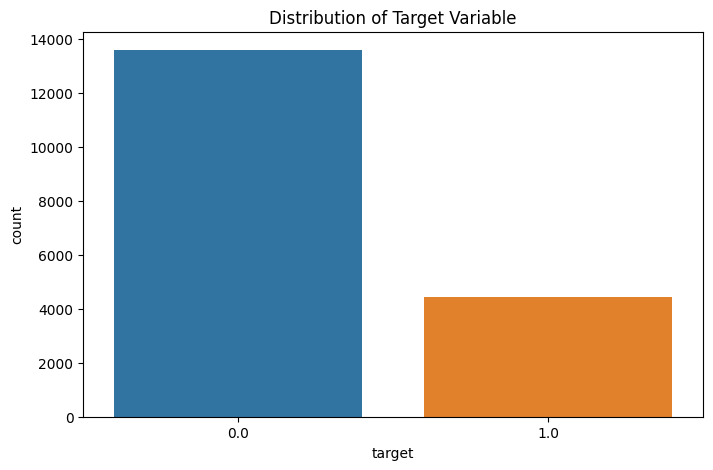

In [14]:
plt.figure(figsize=(8, 5))
sns.countplot(x="target", data=df)
plt.title("Distribution of Target Variable")
plt.show()

Here is the distribution of categorical variables.

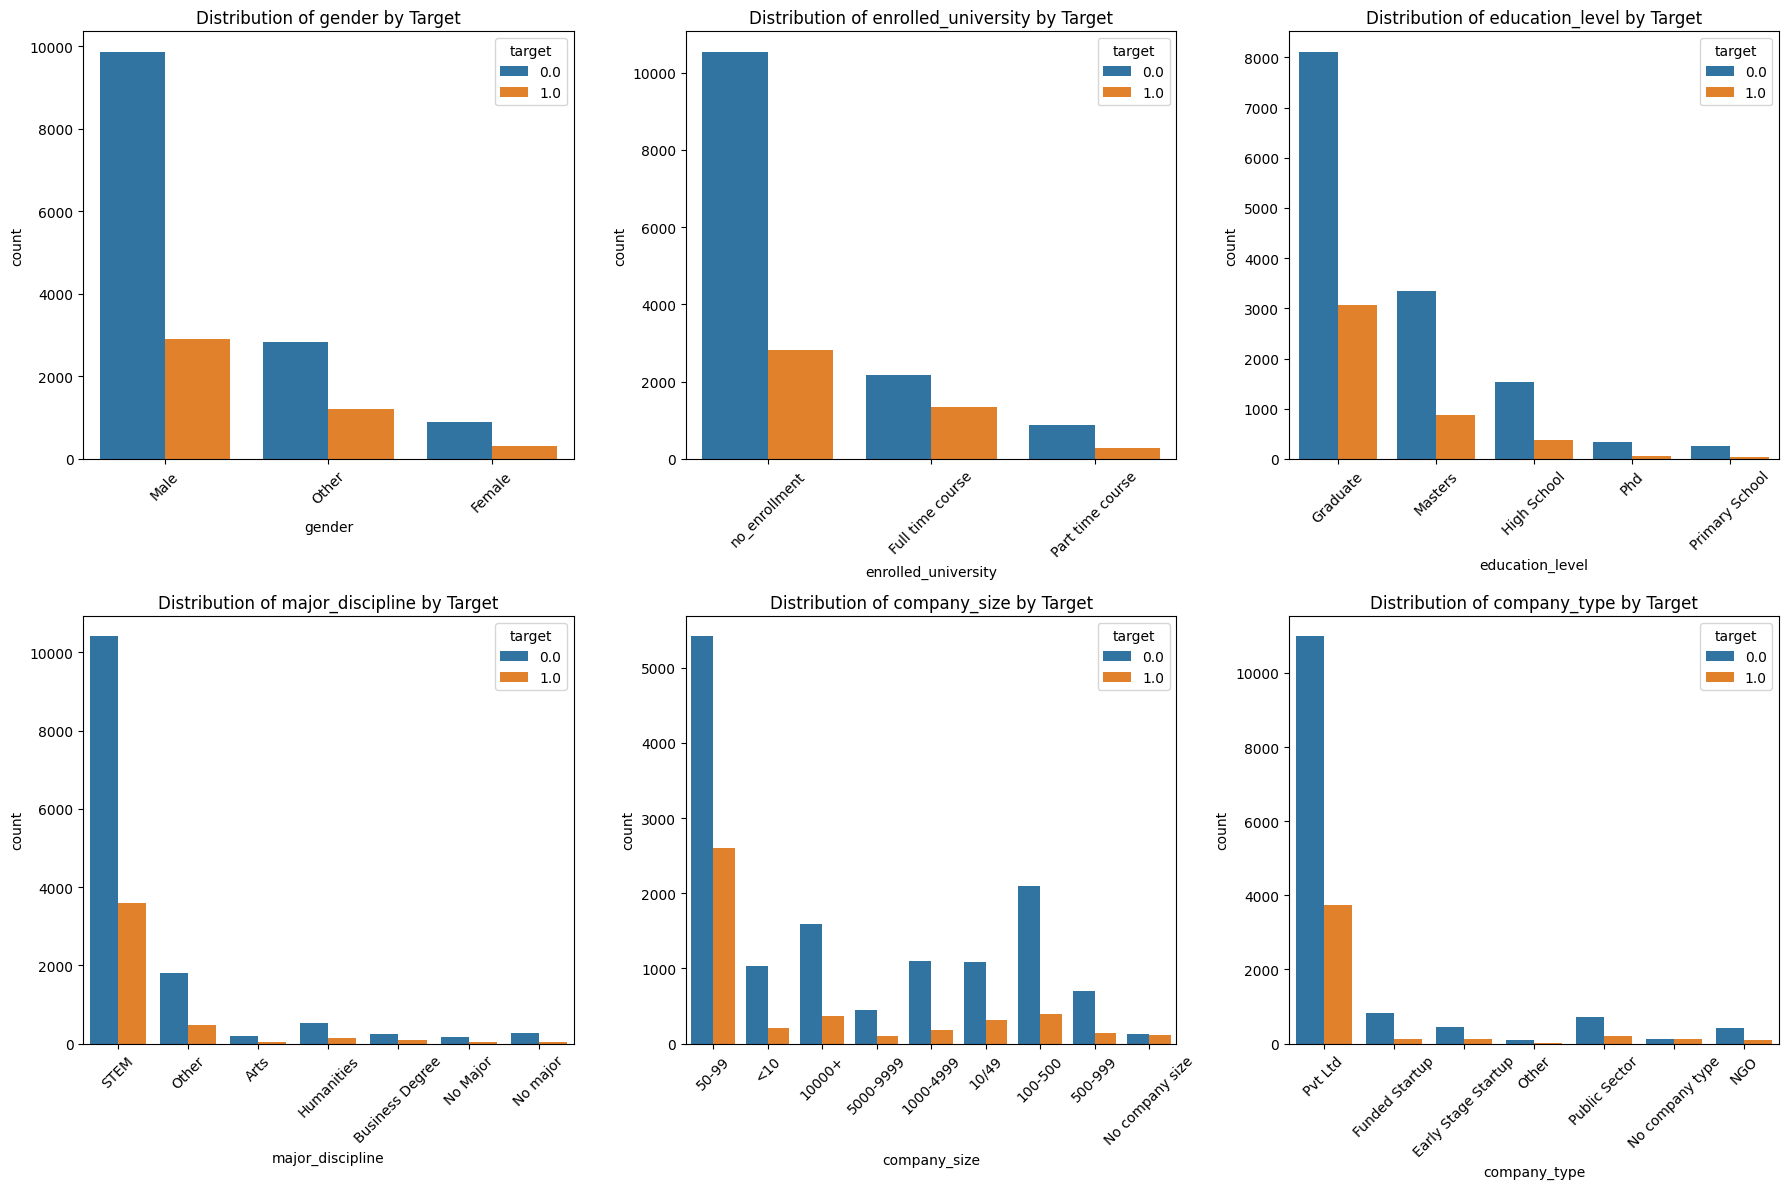

In [15]:
categorical_columns = df.select_dtypes(include=['object']).columns.tolist() # Storing the categorical variable
plot_columns(df, categorical_columns)

Here is the distribution of numerical variables.

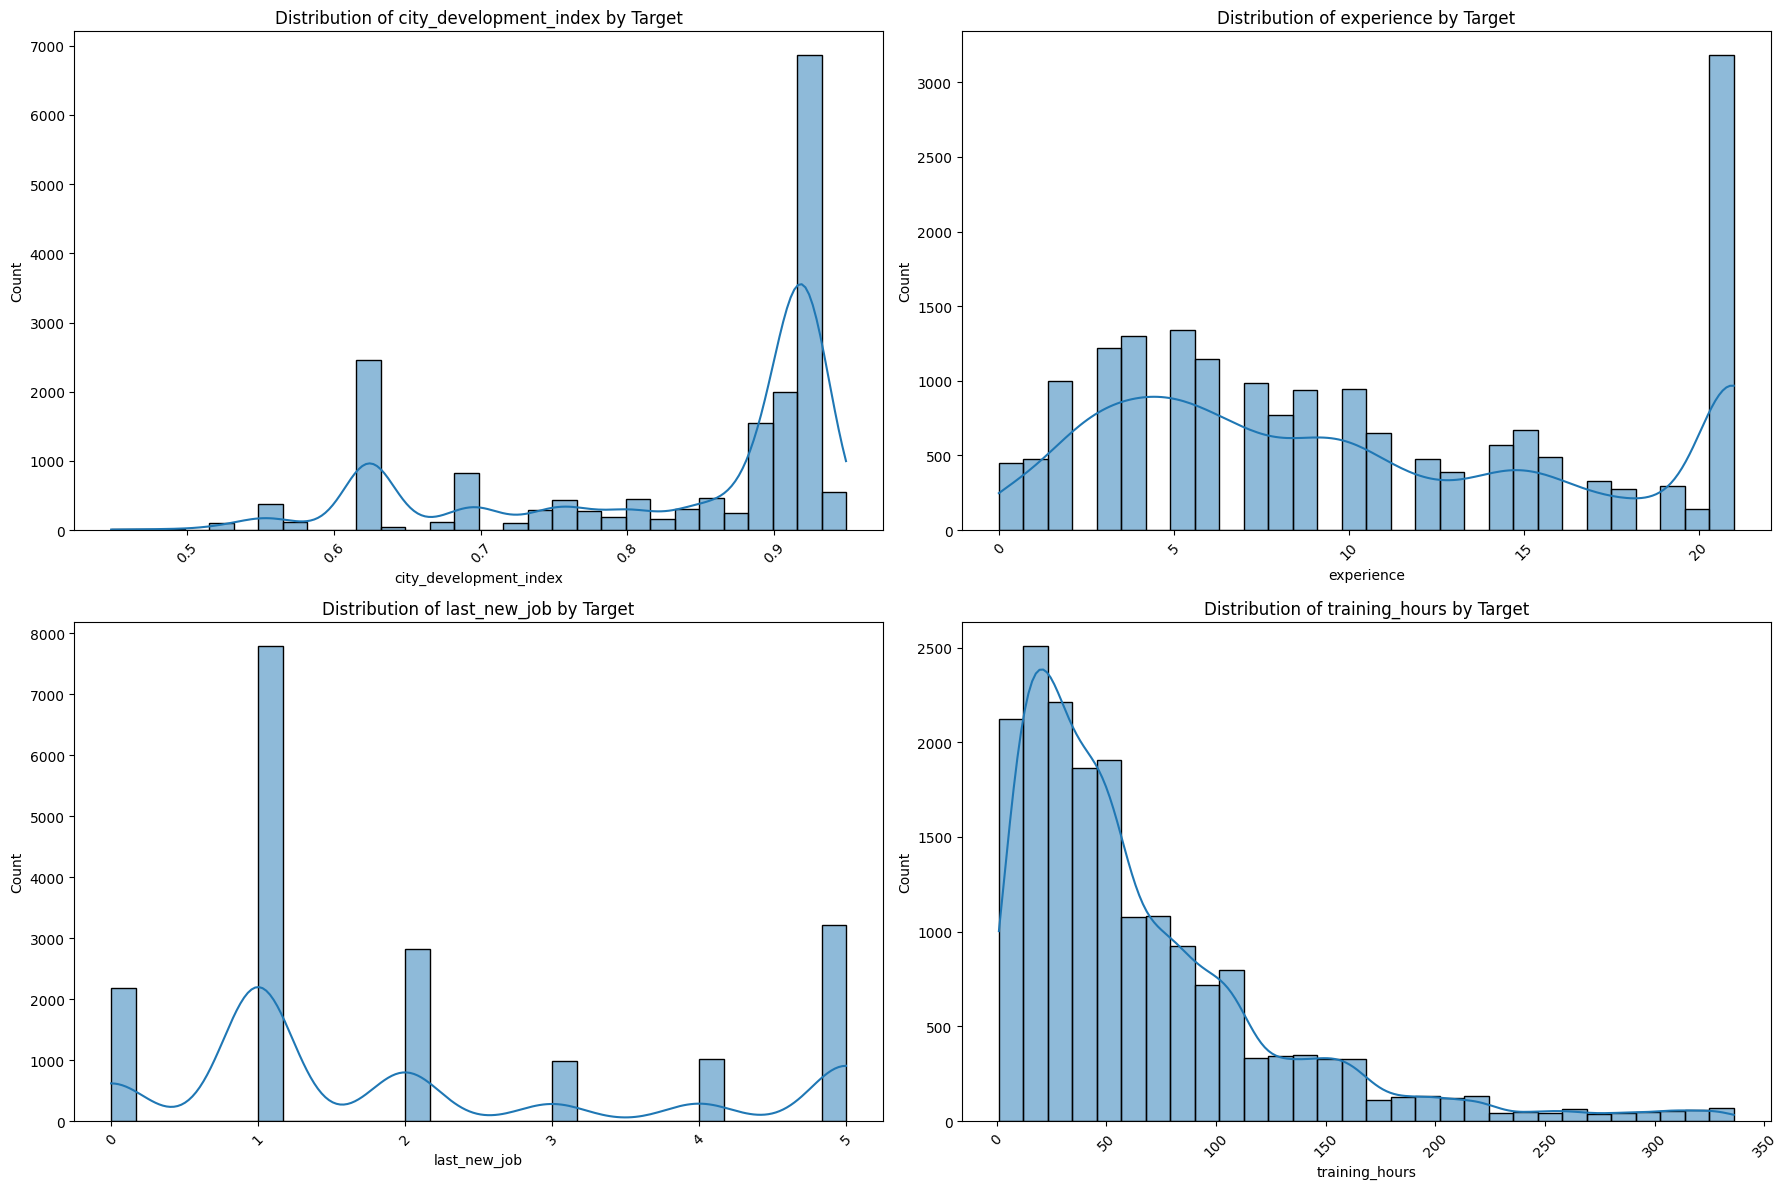

In [16]:
numerical_columns = [col for col in df.columns if col not in categorical_columns and col != "target"]
plot_columns(df, numerical_columns, "hist", 2)

Finally, the correlation matrix.

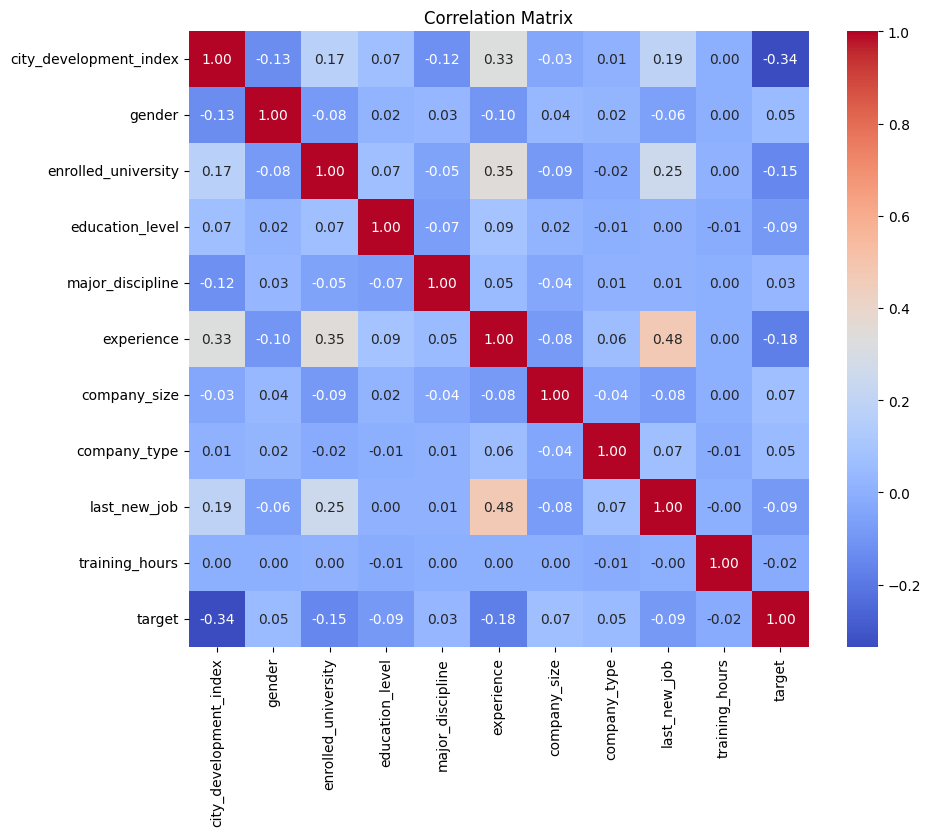

In [17]:
df = labeling(df, categorical_columns)

correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

The analysis of the correlation matrix of the input parameters can provide valuable insights into the relationships between different features in our dataset. Here are several observations we can make from the correlation matrix:
1. strength and Direction of Relationships:
    - positive correlation (closer to +1): indicates that as one variable increases, the other variable tends to increase as well
    - negative correlation (closer to -1): indicates that as one variable increases, the other variable tends to decrease
    - correlation near 0: Suggests a weak or no linear relationship between the variables
2. multicollinearity: high positive or negative correlations between pairs of features may indicate multicollinearity. Multicollinearity can make it challenging for models to distinguish the individual effects of correlated features
3. redundant Information: if two features have a very high positive or negative correlation, it may suggest that they carry similar information. Redundant features may be candidates for dimensionality reduction or feature engineering.
4. identifying Important Features: features that have a higher absolute correlation with the target variable might be more influential in predicting the target.
5. potential Feature Selection: features with low or zero correlation with the target variable may be candidates for removal during feature selection.
6. understanding Feature Relationships: analyzing correlations helps you understand how different features interact with each other, providing domain insights.

Considering the points above and the correlation matrix, it is evident that there is no big correlation between pairs of variables so that one or more could be negligible without biasing the dataset. That's why I decide to not apply further Feature Selection techniques like PCA: they will make our models more computationally and algorithmically complex without bigger advantages.

## Preparation of training and testing databases

I decide to assign 25% of the original data to the test set.

In [18]:
# Split the data into features (X) and target variable (y)
X = df.drop("target", axis=1)
y = df["target"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

print(f"Shape of the training set: {X_train.shape}")
print(f"Shape of the test set: {X_test.shape}")
print(f"Ratios of training ({X_train.shape[0] / X.shape[0]}) and test ({X_test.shape[0] / X.shape[0]}) sets")

# Verification of stratification
print(f"Distribution of the target variable in the training set: {y_train.value_counts(normalize=True)}")
print(f"Distribution of the target variable in the test set: {y_test.value_counts(normalize=True)}")

Shape of the training set: (13510, 10)
Shape of the test set: (4504, 10)
Ratios of training (0.7499722438103698) and test (0.2500277561896303) sets
Distribution of the target variable in the training set: target
0.0    0.755885
1.0    0.244115
Name: proportion, dtype: float64
Distribution of the target variable in the test set: target
0.0    0.750666
1.0    0.249334
Name: proportion, dtype: float64


As it is possible to see, the expected ratio of test database (25% of the original one) is respected.

# Implementation of Machine Learning models
In order to prepare classification models, I have picked two techniques, Multi-Layer Perceptron and Random Forest Classifier, to compare a typical neuronal-based Machine Learning classifier with a  technique based on ensemble learning.

Both will be trained and their results compared, in order to pick the more performing one for further analysis.

## Multi-Layer Perceptron (MLP)

In [19]:
mlp_model = MLPClassifier(hidden_layer_sizes=(64, 20), max_iter=1000, random_state=42, activation="logistic", learning_rate="adaptive")
mlp_model.fit(X_train, y_train)
mlp_y_pred = mlp_model.predict(X_test)
mlp_y_proba = mlp_model.predict_proba(X_test)[:, 1]

mlp_accuracy = accuracy_score(y_test, mlp_y_pred)
mlp_roc_auc = roc_auc_score(y_test, mlp_y_proba)
mlp_class_report = classification_report(y_test, mlp_y_pred)

print(f"MLP Accuracy: {mlp_accuracy:.2f}")
print(f"MLP ROC-AUC: {mlp_roc_auc:.2f}")
print("MLP Classification Report:")
print(mlp_class_report)

MLP Accuracy: 0.78
MLP ROC-AUC: 0.75
MLP Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.94      0.86      3381
         1.0       0.61      0.28      0.38      1123

    accuracy                           0.78      4504
   macro avg       0.70      0.61      0.62      4504
weighted avg       0.75      0.78      0.74      4504



This is just a preliminary attempt: performances could be improved, for instance, by tuning the training parameters.

## Random Forest Classifier

In [20]:
rf_model = RandomForestClassifier(random_state=42, criterion="entropy")
rf_model.fit(X_train, y_train)
rf_y_pred = rf_model.predict(X_test)
rf_y_proba = rf_model.predict_proba(X_test)[:, 1]

rf_accuracy = accuracy_score(y_test, rf_y_pred)
rf_roc_auc = roc_auc_score(y_test, rf_y_proba)
rf_class_report = classification_report(y_test, rf_y_pred)

print(f"Random Forest Accuracy: {rf_accuracy:.2f}")
print(f"Random Forest ROC-AUC: {rf_roc_auc:.2f}")
print("Random Forest Classification Report:")
print(rf_class_report)

Random Forest Accuracy: 0.76
Random Forest ROC-AUC: 0.75
Random Forest Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85      3381
         1.0       0.54      0.38      0.44      1123

    accuracy                           0.76      4504
   macro avg       0.67      0.63      0.65      4504
weighted avg       0.74      0.76      0.75      4504



Even in this case, this is just a preliminary attempt: as for MLP, performances could be improved, for instance, by tuning the training parameters.

According to the application, it could be useful to evaluate the performances of a classifier on the basis of:
- accuracy, if the mere evaluation of the number of correct evaluations over all evaluations is enough
- precision, if robustness about the correct evaluations is more important than the other elements (e.g. in medical treatment of heart disease, when it is crucial that we avoid initiating treatment for a patient who, in reality, does not have a heart ailment, even if our model has predicted otherwise)
- recall, if it is more important to have high accuracy in identifying the relevant data (e.g., when it is important to detect patient affected by heart disease in order to start proper medical treatments)
- f1-score, which F1-Score serves as a metric that integrates both precision and recall, often characterized as the harmonic mean of these two components, useful when it is important to balance the positive effects of precision and recall.

In our context, the MLP and the Random Forest classifiers have very close performances. Therefore, I will continue describing both of them.

## Save models to Joblib files
Let me save the models, now: they will be useful later for the API endpoint.

In [21]:
models = {"mlp": mlp_model, "rf": rf_model}
for model_name, model in models.items():
    save_model(model, f"{model_name}_model.joblib")

## Report for the MLP


Multi-Layer Perceptron Results:
Confusion Matrix:
[[3177  204]
 [ 807  316]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.80      0.94      0.86      3381
         1.0       0.61      0.28      0.38      1123

    accuracy                           0.78      4504
   macro avg       0.70      0.61      0.62      4504
weighted avg       0.75      0.78      0.74      4504


ROC-AUC: 0.75
Prec-Recall AUC: 0.49


<Axes: >

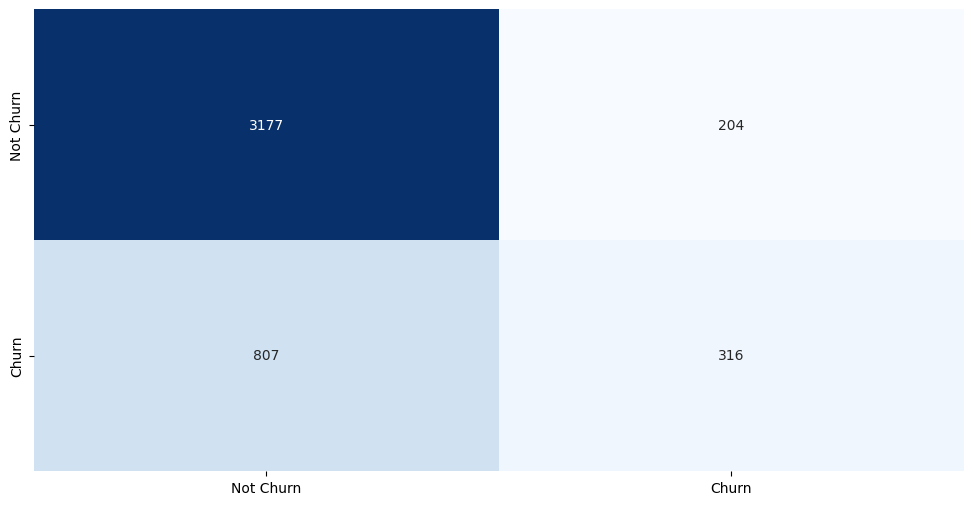

In [22]:
# Confusion matrix and classification report for MLP
mlp_conf_matrix = confusion_matrix(y_test, mlp_y_pred)
mlp_class_report = classification_report(y_test, mlp_y_pred)

# ROC-AUC for MLP
mlp_roc_auc = roc_auc_score(y_test, mlp_y_proba)

# Precision-Recall Curve for MLP
precision_mlp, recall_mlp, _ = precision_recall_curve(y_test, mlp_y_proba)
pr_auc_mlp = auc(recall_mlp, precision_mlp)

# Display results
print("\nMulti-Layer Perceptron Results:")
print(f"Confusion Matrix:\n{mlp_conf_matrix}")
print(f"\nClassification Report:\n{mlp_class_report}")
print(f"\nROC-AUC: {mlp_roc_auc:.2f}")
print(f"Prec-Recall AUC: {pr_auc_mlp:.2f}")

# Visualization
plt.figure(figsize=(12, 6))
sns.heatmap(mlp_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])

In order to remark the feature importance, let us depict the evaluation of the test set. Unfortunately, due to the amount of data, the SHAP library cannot be used.

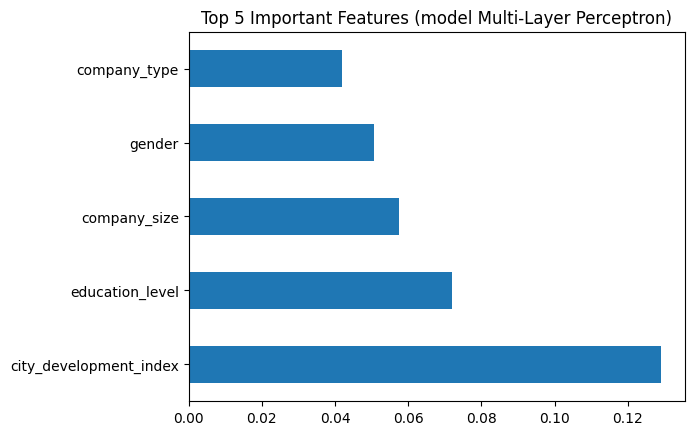

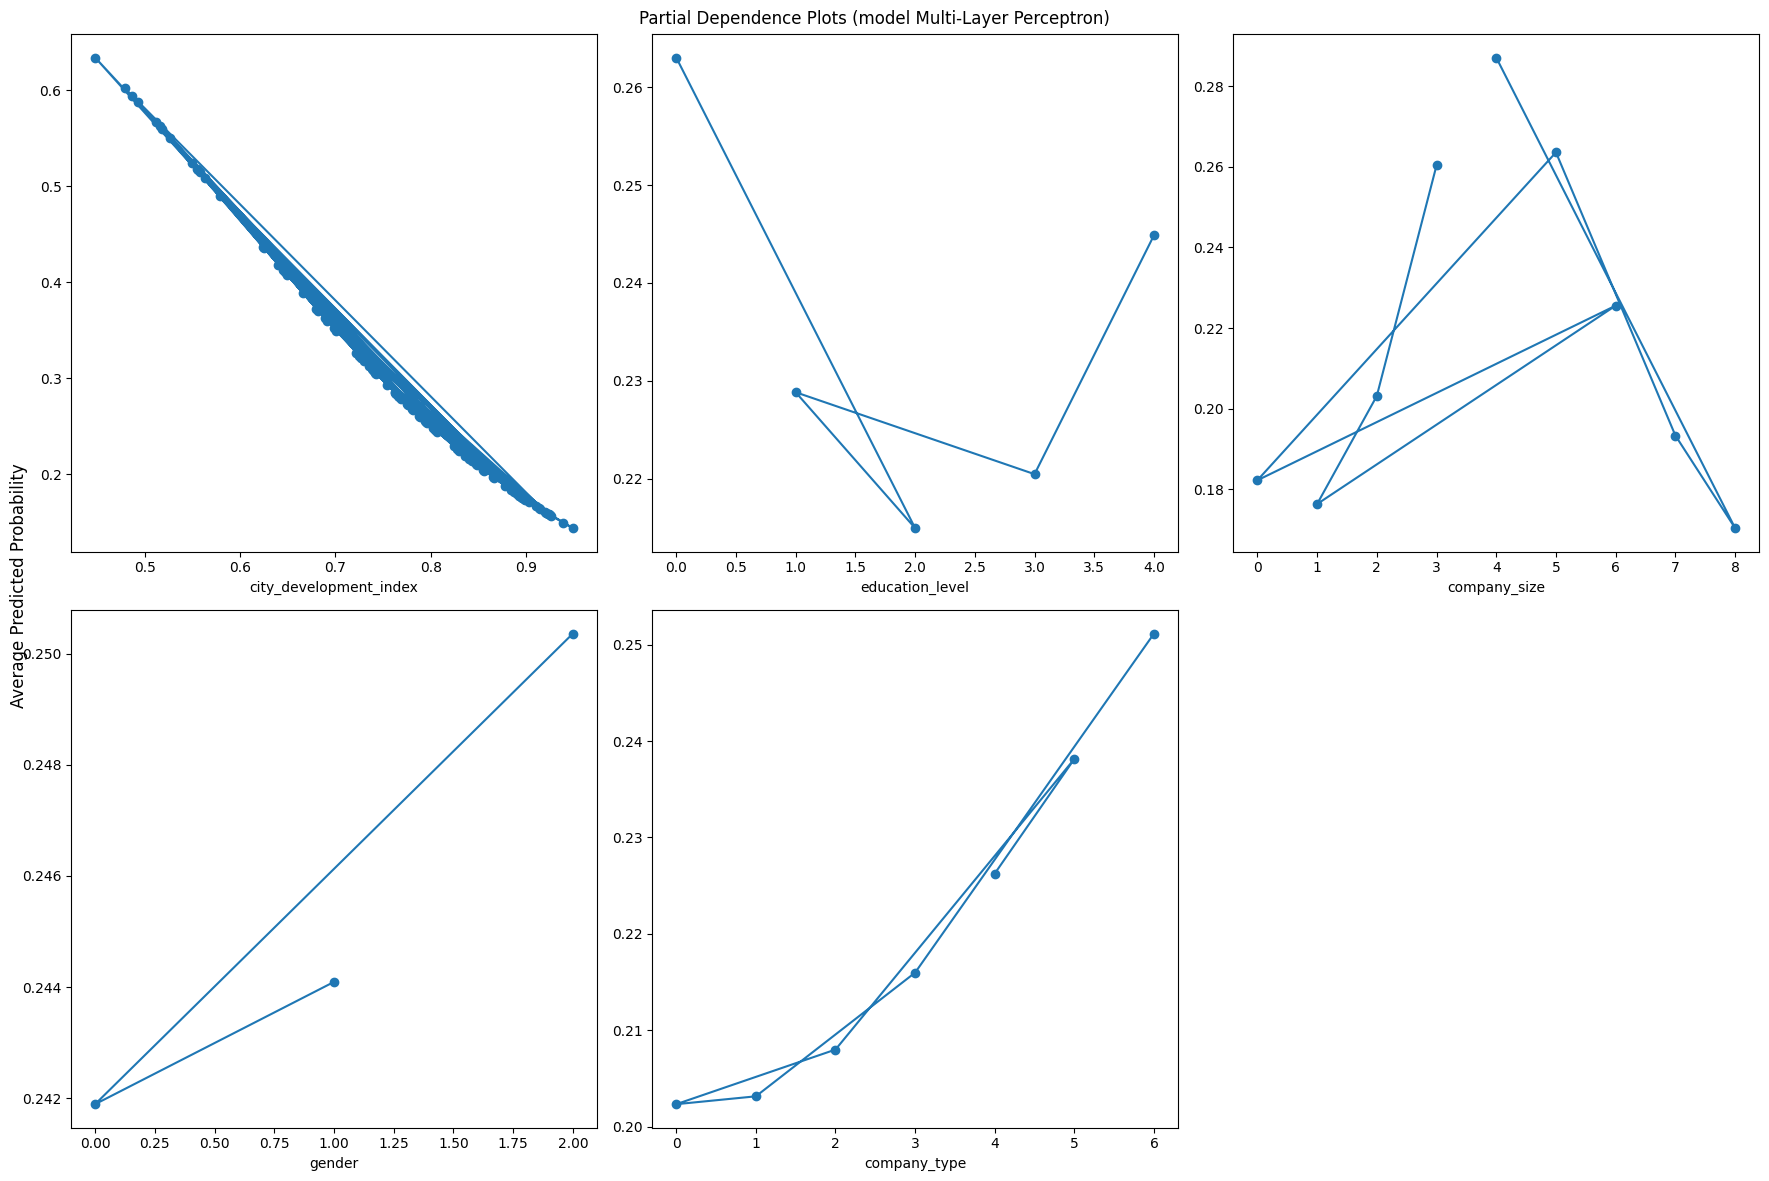

In [23]:
# # Create an explainer object for the MLP model using KernelExplainer
# explainer_mlp = shap.KernelExplainer(mlp_model.predict_proba, X_test)

# # Calculate SHAP values
# shap_values_mlp = explainer_mlp.shap_values(X_test)

# # Summary plot of feature importance for MLP
# shap.summary_plot(shap_values_mlp[1], X_test, plot_type="bar", show=False)
# plt.title('SHAP Summary Plot - Feature Importance for MLP')
# plt.show()

top = feature_importance_plot(mlp_model, "Multi-Layer Perceptron", X_test)
partial_dependence_plot(mlp_model, "Multi-Layer Perceptron", X_test, top)

As it is possible to see, the five most important features for the MLP are: _city_development_index_, _education_level_, _company_size_, _gender_, _company_type_. These are the most important elements characterizing the possibility of employee / candidate churning.

## Report for the Random Forest Classifier


Random Forest Results:
Confusion Matrix:
[[3011  370]
 [ 697  426]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.81      0.89      0.85      3381
         1.0       0.54      0.38      0.44      1123

    accuracy                           0.76      4504
   macro avg       0.67      0.63      0.65      4504
weighted avg       0.74      0.76      0.75      4504


ROC-AUC: 0.75
Prec-Recall AUC: 0.47


<Axes: >

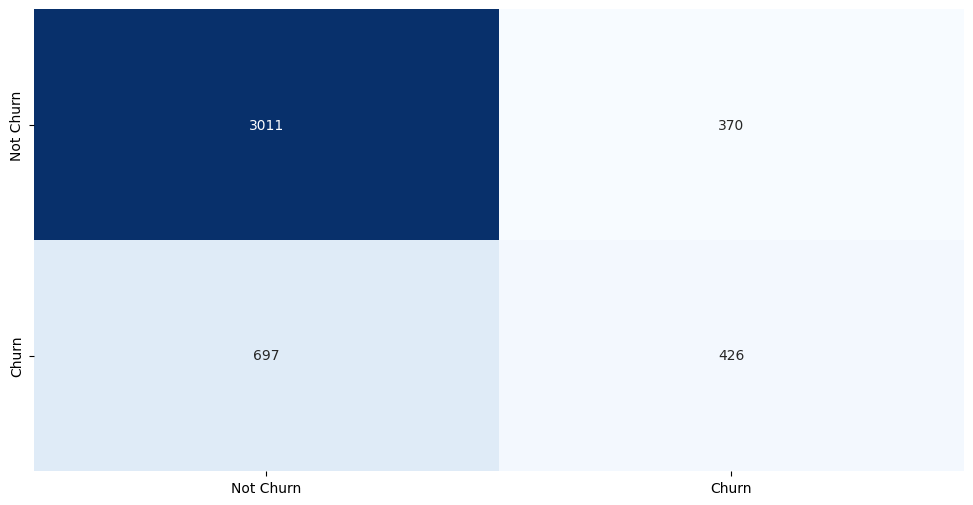

In [24]:
# Confusion matrix and classification report for Random Forest
rf_conf_matrix = confusion_matrix(y_test, rf_y_pred)
rf_class_report = classification_report(y_test, rf_y_pred)

# ROC-AUC for Random Forest
rf_roc_auc = roc_auc_score(y_test, rf_y_proba)

# Precision-Recall Curve for Random Forest
precision_rf, recall_rf, _ = precision_recall_curve(y_test, rf_y_proba)
pr_auc_rf = auc(recall_rf, precision_rf)

# Display results
print("\nRandom Forest Results:")
print(f"Confusion Matrix:\n{rf_conf_matrix}")
print(f"\nClassification Report:\n{rf_class_report}")
print(f"\nROC-AUC: {rf_roc_auc:.2f}")
print(f"Prec-Recall AUC: {pr_auc_rf:.2f}")

# Feature importance for Random Forest
feature_importance_rf = pd.Series(rf_model.feature_importances_, index=X.columns)
top_features_rf = feature_importance_rf.nlargest(10)

# Visualization
plt.figure(figsize=(12, 6))
sns.heatmap(rf_conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["Not Churn", "Churn"], yticklabels=["Not Churn", "Churn"])

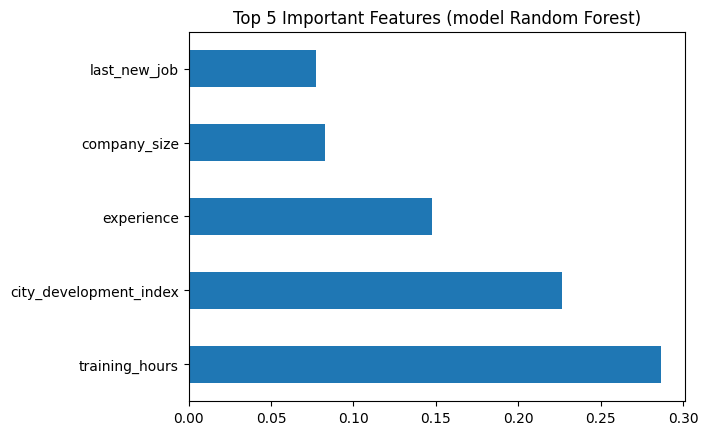

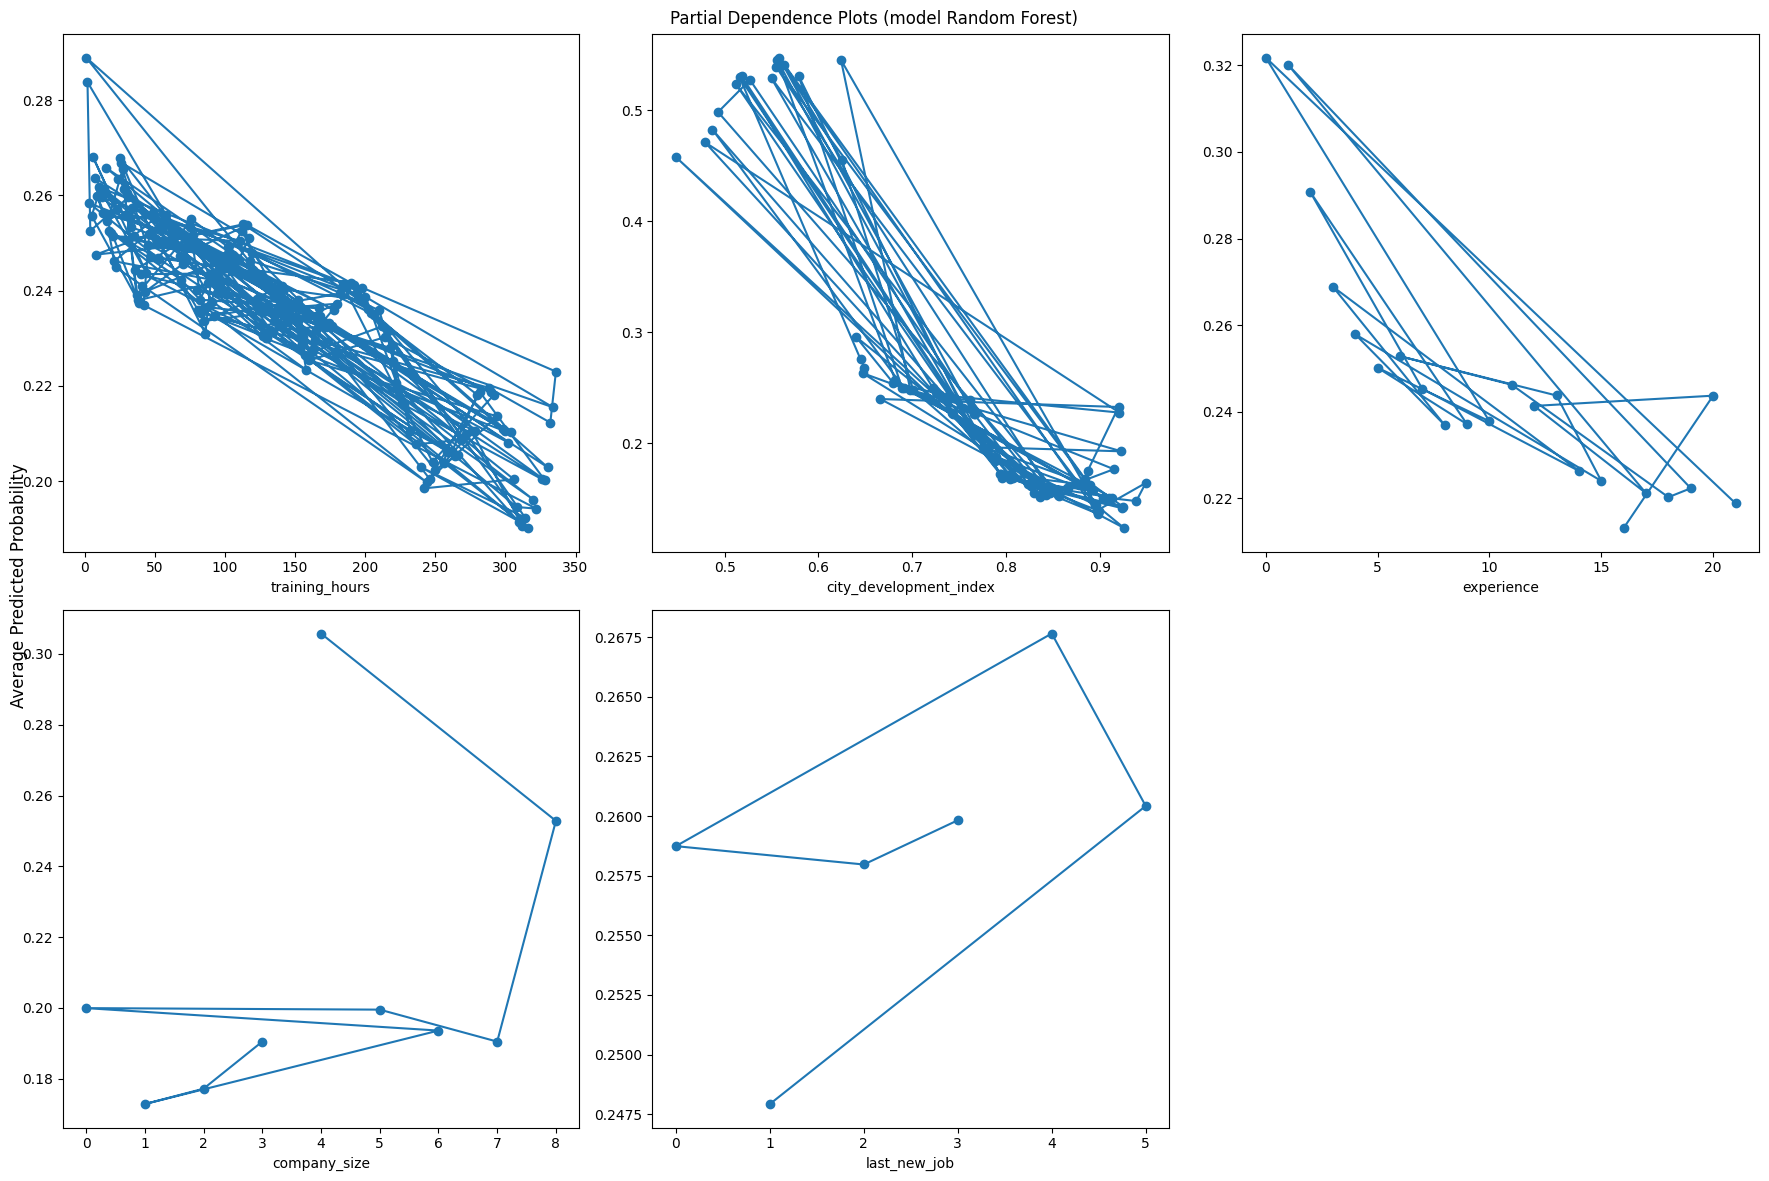

In [25]:
# # Create an explainer object for the Random Forest model
# explainer_rf = shap.TreeExplainer(rf_model)
# shap_values_rf = explainer_rf.shap_values(X_test)

# # Summary plot of feature importance for Random Forest
# shap.summary_plot(shap_values_rf[1], X_test, plot_type="bar", show=False)
# plt.title('SHAP Summary Plot - Feature Importance for Random Forest')
# plt.show()

top = feature_importance_plot(rf_model, "Random Forest", X_test)
partial_dependence_plot(rf_model, "Random Forest", X_test, top)

For the Random Forest model, the five most important are: _training_hours_, _city_development_index_, _experience_, _company_size_ and _last_new_job_. According to the Random Forest classifier, it looks like a candidate is more prone to churn if he / she is trained, located in a high-developed city, with a relevant amount of experience and coming from a new job in a consistently important company.